#  Loan Default Prediction and Analysis

---

## Overview
This analysis focuses on developing a data-driven approach to predict loan defaults for a mid-sized bank. By leveraging supervised machine learning techniques, the goal is to identify customers who are at high risk of defaulting on their loans. Additionally, the analysis aims to uncover patterns and insights in customer demographics, account balances, and transaction behaviors to recommend strategies for reducing default rates.

---

#### IMPORT DATASET

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("Data_Neo.csv")
data.head(10)

,Customer_ID,Age,Gender,Income,Credit_Score,Loan_Amount,Loan_Term,Number_of_Loans,Transaction_Count,Account_Balance,Marital_Status,Credit_Default_Status,Job
0,1,69,Male,37114,678,4905.22,12,1,18,3836.25,married,0,Other
1,2,98,Male,-49215,778,6374.88,12,3,4,5300.84,unmarried,0,Other
2,3,60,Female,34352,696,6622.15,36,5,8,5668.57,married,0,Other
3,4,51,Male,121193,655,25610.96,24,2,10,9202.42,divorced,0,Other
4,5,46,Female,115249,702,22509.28,72,5,13,8138.34,married,0,Other
5,6,97,Female,62479,533,11262.37,72,4,0,1559.15,married,1,Other
6,7,24,Male,34224,763,8858.11,12,5,21,6584.89,unmarried,0,Other
7,8,54,Female,98236,480,34270.35,36,2,3,2260.55,married,1,Other
8,9,46,Female,60480,718,22461.11,12,5,9,6025.93,unmarried,0,IT Professional
9,10,30,Male,104003,677,12096.57,60,5,6,5864.46,divorced,0,Other


In [3]:
print("The shape of the dataset is: {}".format(data.shape))

The shape of the dataset is: (5000, 13)


#### DATA CLEANING

###### 1. Missing Values

In [4]:
missing_values = data.isnull().sum()
missing_values

Customer_ID                0
Age                        0
Gender                   272
Income                     0
Credit_Score               0
Loan_Amount              305
Loan_Term                  0
Number_of_Loans            0
Transaction_Count          0
Account_Balance            0
Marital_Status           298
Credit_Default_Status      0
Job                        0
dtype: int64

In [5]:
missing_values = missing_values[missing_values > 0]
missing_values

Gender            272
Loan_Amount       305
Marital_Status    298
dtype: int64

In [6]:
data['Gender'].fillna("Unknown", inplace=True)
data['Loan_Amount'].fillna(data['Loan_Amount'].median(), inplace=True)
data['Marital_Status'].fillna("Unknown",inplace=True)

In [7]:
missing_replacement = data.isnull().sum()
missing_replacement

Customer_ID              0
Age                      0
Gender                   0
Income                   0
Credit_Score             0
Loan_Amount              0
Loan_Term                0
Number_of_Loans          0
Transaction_Count        0
Account_Balance          0
Marital_Status           0
Credit_Default_Status    0
Job                      0
dtype: int64

##### 2. Negative Values

In [8]:
# Initialize dictionary to store invalid data details
invalid_data = {}

# Check for invalid data in numeric columns
for column in data.select_dtypes(include=['int64', 'float64']).columns:
    # Define specific invalid conditions for each column
    if column == 'Age':
        invalid_rows = data[data[column] <= 0]  # Age cannot be <= 0
    elif column == 'Credit_Score':
        invalid_rows = data[(data[column] < 300) | (data[column] > 850)]  # Out of valid range
    elif column in ['Income', 'Loan_Amount', 'Account_Balance']:
        invalid_rows = data[data[column] < 0]  # Negative values are invalid
    else:
        invalid_rows = pd.DataFrame()  # No invalid data criteria for other columns

    # Add to dictionary if invalid rows are found
    invalid_data[column] = {
        'Invalid_Count': len(invalid_rows),
        'Examples': invalid_rows.head()  # Show a few examples
    }

# Print invalid data for columns with invalid rows
for column, details in invalid_data.items():
    if details['Invalid_Count'] > 0:
        print(f"Invalid data detected in column: {column}")
        print(f"Number of invalid rows: {details['Invalid_Count']}")
        print("Examples of invalid data:")
        print(details['Examples'])
        print("-" * 50)


Invalid data detected in column: Income
Number of invalid rows: 14
Examples of invalid data:
      Customer_ID  Age   Gender  Income  Credit_Score  Loan_Amount  Loan_Term  \
1               2   98     Male  -49215           778      6374.88         12   
266           267   28  Unknown  -33355           783     11553.85         12   
442           443   23     Male  -37412           473      4323.70         36   
750           751   19   Female  -43827           797     11771.63         60   
1102         1103   32     Male  -88718           680     10963.08         48   

      Number_of_Loans  Transaction_Count  Account_Balance Marital_Status  \
1                   3                  4          5300.84      unmarried   
266                 5                  2          4100.46      unmarried   
442                 5                 10          1575.55        married   
750                 5                  2          7394.73      unmarried   
1102                2                 16

In [9]:
# Remove rows with invalid data in 'Income' and 'Loan_Amount'
data_cleaned = data[(data['Income'] >= 0) & (data['Loan_Amount'] >= 0)]

# Verify if all invalid data has been removed
invalid_data_after_removal = {
    'Income': len(data_cleaned[data_cleaned['Income'] < 0]),
    'Loan_Amount': len(data_cleaned[data_cleaned['Loan_Amount'] < 0])
}

# Display the updated shape of the dataset and invalid data counts
data_cleaned_shape = data_cleaned.shape
invalid_data_after_removal, data_cleaned_shape


({'Income': 0, 'Loan_Amount': 0}, (4974, 13))

###### 3. Outliers

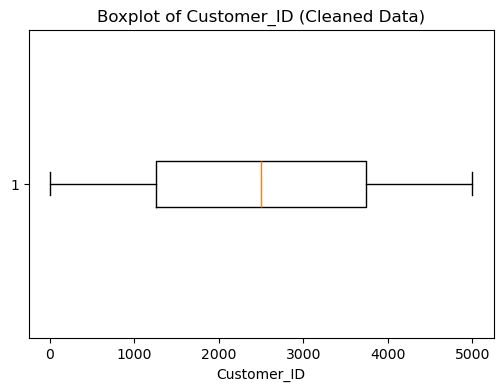

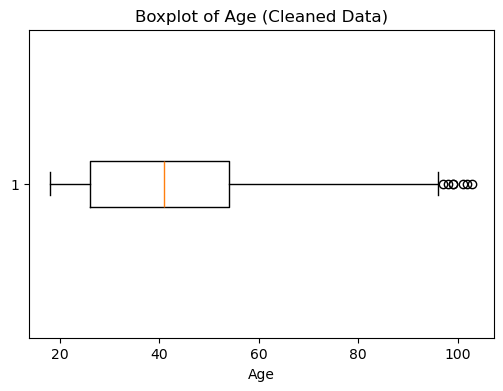

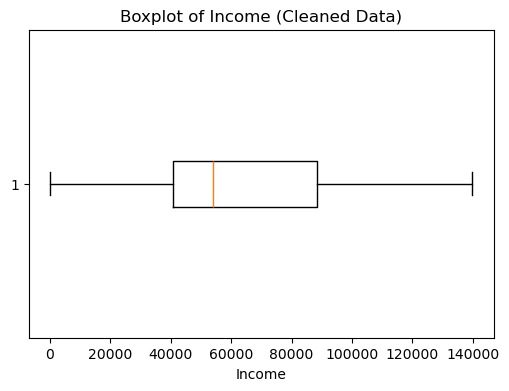

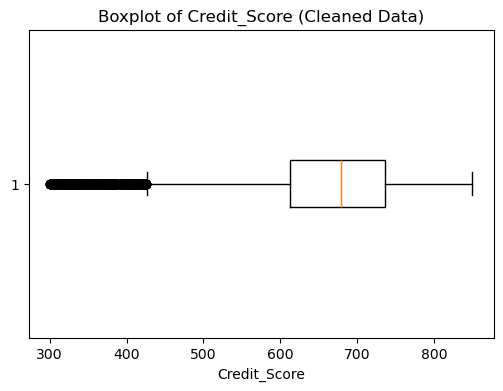

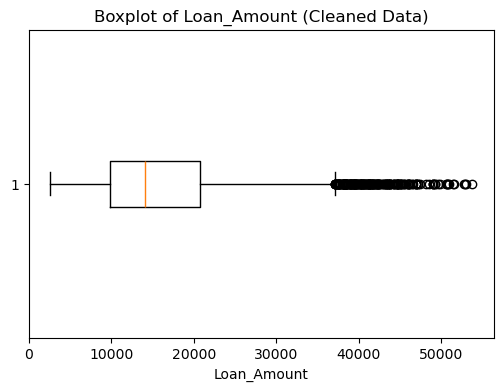

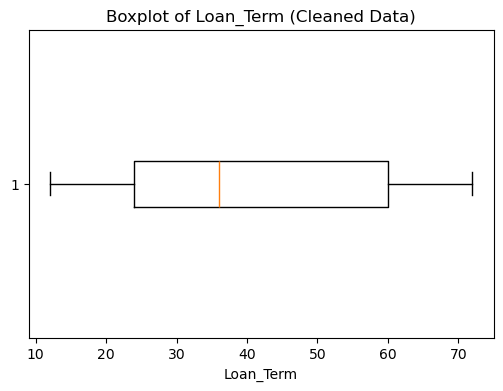

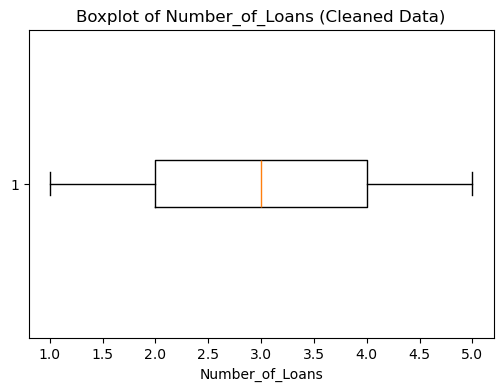

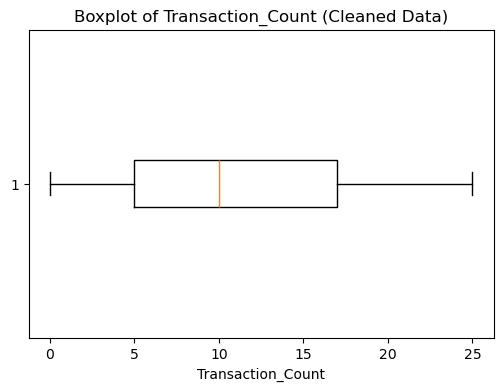

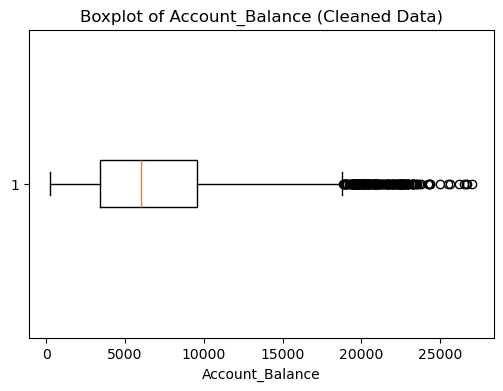

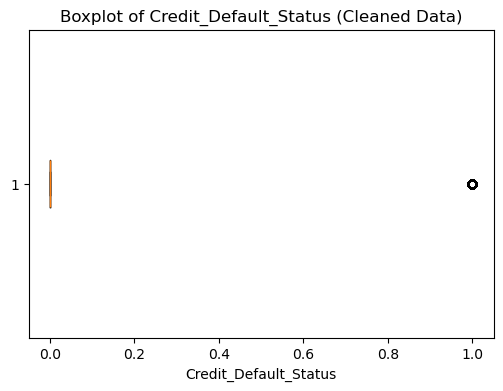

{'Customer_ID': 0,
 'Age': 7,
 'Income': 0,
 'Credit_Score': 467,
 'Loan_Amount': 207,
 'Loan_Term': 0,
 'Number_of_Loans': 0,
 'Transaction_Count': 0,
 'Account_Balance': 173,
 'Credit_Default_Status': 1094}

In [10]:
import matplotlib.pyplot as plt

# Identify numeric columns for outlier detection after cleaning invalid data
numeric_columns_cleaned = data_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Dictionary to store detected outliers
outliers_detected_cleaned = {}

# Create boxplots and detect outliers using IQR for cleaned data
for column in numeric_columns_cleaned:
    plt.figure(figsize=(6, 4))
    plt.boxplot(data_cleaned[column], vert=False)
    plt.title(f"Boxplot of {column} (Cleaned Data)")
    plt.xlabel(column)
    plt.show()
    
    # Calculate the IQR for outlier detection
    Q1 = data_cleaned[column].quantile(0.25)
    Q3 = data_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Detect outliers based on 1.5*IQR rule
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data_cleaned[(data_cleaned[column] < lower_bound) | (data_cleaned[column] > upper_bound)]
    
    outliers_detected_cleaned[column] = len(outliers)

# Display the count of outliers for each numeric column in the cleaned data
outliers_detected_cleaned


## 1. Customer Demographics Analysis:


In [11]:
# Separate defaulters and non-defaulters for analysis
defaulters = data_cleaned[data_cleaned['Credit_Default_Status'] == 1]
non_defaulters = data_cleaned[data_cleaned['Credit_Default_Status'] == 0]

# Calculate average loan amount and loan term for both groups
average_loan_default = defaulters['Loan_Amount'].mean()
average_term_default = defaulters['Loan_Term'].mean()

average_loan_non_default = non_defaulters['Loan_Amount'].mean()
average_term_non_default = non_defaulters['Loan_Term'].mean()

# Analyze customer demographics and their relation to defaults
demographics_analysis = {
    'Age': {
        'Defaulters': defaulters['Age'].mean(),
        'Non-Defaulters': non_defaulters['Age'].mean()
    },
    'Income': {
        'Defaulters': defaulters['Income'].mean(),
        'Non-Defaulters': non_defaulters['Income'].mean()
    },
    'Loan_Amount': {
        'Defaulters': average_loan_default,
        'Non-Defaulters': average_loan_non_default
    },
    'Loan_Term': {
        'Defaulters': average_term_default,
        'Non-Defaulters': average_term_non_default
    }
}

# Display the analysis results
demographics_analysis



{'Age': {'Defaulters': 39.40859232175503,
  'Non-Defaulters': 41.741494845360826},
 'Income': {'Defaulters': 56922.64442413163,
  'Non-Defaulters': 66630.84974226804},
 'Loan_Amount': {'Defaulters': 14390.453957952466,
  'Non-Defaulters': 17046.4057371134},
 'Loan_Term': {'Defaulters': 42.142595978062154,
  'Non-Defaulters': 42.00309278350515}}

In [12]:
# Use value_counts without normalization
demographics_analysis['Occupation'] = {
    'Defaulters': defaulters['Job'].value_counts().to_dict(),
    'Non-Defaulters': non_defaulters['Job'].value_counts().to_dict()
}
demographics_analysis['Occupation'] 

{'Defaulters': {'Other': 735, 'Entry-Level': 359},
 'Non-Defaulters': {'Other': 2734,
  'IT Professional': 479,
  'Skilled Worker': 350,
  'Entry-Level': 227,
  'Executive': 54,
  'Managerial': 36}}

##### Visualization for Occupation

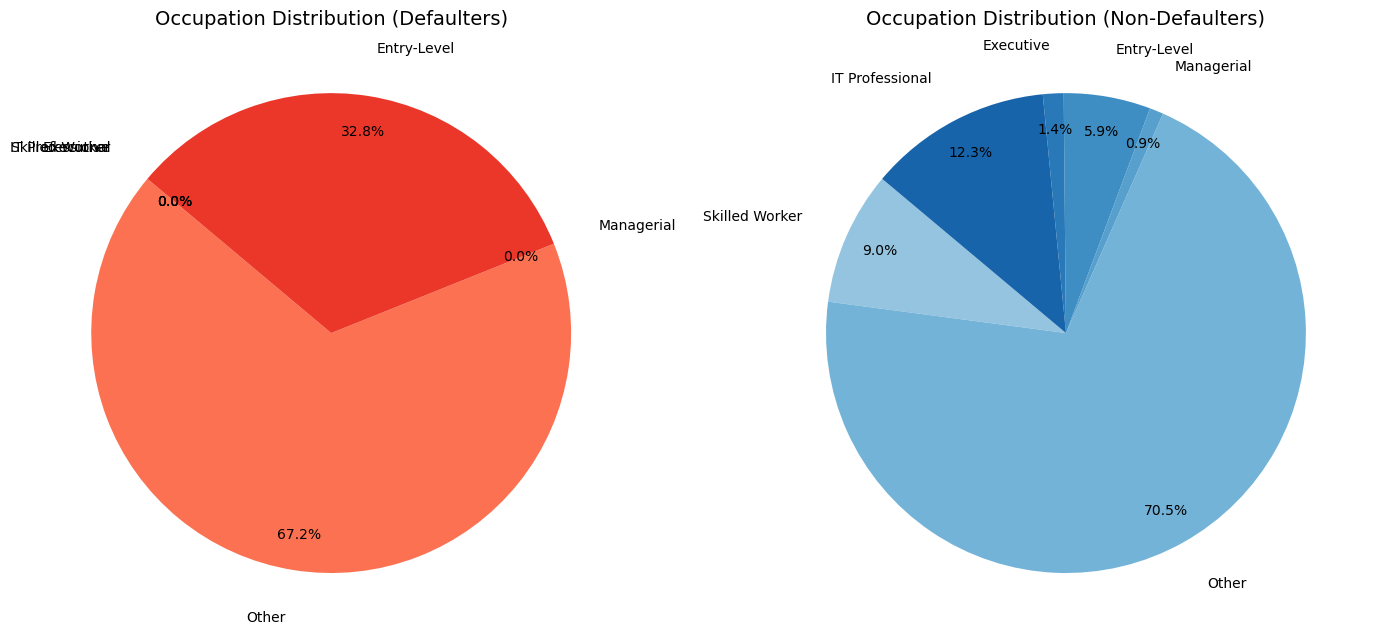

In [13]:
# Prepare data for bar plot
# Assign variables for defaulters and non-defaulters
occupation_defaulters = demographics_analysis['Occupation']['Defaulters']
occupation_non_defaulters = demographics_analysis['Occupation']['Non-Defaulters']
occupation_labels = list(set(occupation_defaulters.keys()).union(set(occupation_non_defaulters.keys())))
defaulters_occupation_values = [occupation_defaulters.get(job, 0) for job in occupation_labels]
non_defaulters_occupation_values = [occupation_non_defaulters.get(job, 0) for job in occupation_labels]

import matplotlib.pyplot as plt
import numpy as np

# Prepare data for pie charts
occupation_labels = list(set(occupation_defaulters.keys()).union(set(occupation_non_defaulters.keys())))
defaulters_pie_data = [occupation_defaulters.get(label, 0) for label in occupation_labels]
non_defaulters_pie_data = [occupation_non_defaulters.get(label, 0) for label in occupation_labels]

# Create subplots for side-by-side pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for Defaulters
axes[0].pie(
    defaulters_pie_data,
    labels=occupation_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Reds(np.linspace(0.4, 0.8, len(defaulters_pie_data))),
    labeldistance=1.2,  # Increase label distance from center
    pctdistance=0.85    # Adjust percentage label distance
)
axes[0].set_title('Occupation Distribution (Defaulters)', fontsize=14)

# Pie chart for Non-Defaulters
axes[1].pie(
    non_defaulters_pie_data,
    labels=occupation_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Blues(np.linspace(0.4, 0.8, len(non_defaulters_pie_data))),
    labeldistance=1.2,  # Increase label distance from center
    pctdistance=0.85    # Adjust percentage label distance
)
axes[1].set_title('Occupation Distribution (Non-Defaulters)', fontsize=14)

plt.tight_layout()
plt.show()



In [14]:
import pandas as pd

# Define categories for analysis
age_bins = [18, 30, 40, 50, 60, 100]
age_labels = ['18-30', '31-40', '41-50', '51-60', '61+']

income_bins = [0, 30000, 50000, 70000, 100000, 200000]
income_labels = ['0-30k', '30k-50k', '50k-70k', '70k-100k', '100k+']

loan_bins = [0, 5000, 10000, 20000, 50000, 100000]
loan_labels = ['0-5k', '5k-10k', '10k-20k', '20k-50k', '50k+']

term_bins = [0, 12, 24, 36, 48, 60, 120]
term_labels = ['0-12m', '13-24m', '25-36m', '37-48m', '49-60m', '60m+']

# Add categorical columns to the dataset
data_cleaned['Age_Group'] = pd.cut(data_cleaned['Age'], bins=age_bins, labels=age_labels, right=False)
data_cleaned['Income_Group'] = pd.cut(data_cleaned['Income'], bins=income_bins, labels=income_labels, right=False)
data_cleaned['Loan_Amount_Group'] = pd.cut(data_cleaned['Loan_Amount'], bins=loan_bins, labels=loan_labels, right=False)
data_cleaned['Loan_Term_Group'] = pd.cut(data_cleaned['Loan_Term'], bins=term_bins, labels=term_labels, right=False)

# Perform analysis for each category
age_analysis = data_cleaned.groupby('Age_Group')['Credit_Default_Status'].value_counts(normalize=True).unstack()
income_analysis = data_cleaned.groupby('Income_Group')['Credit_Default_Status'].value_counts(normalize=True).unstack()
loan_amount_analysis = data_cleaned.groupby('Loan_Amount_Group')['Credit_Default_Status'].value_counts(normalize=True).unstack()
loan_term_analysis = data_cleaned.groupby('Loan_Term_Group')['Credit_Default_Status'].value_counts(normalize=True).unstack()

# Rename columns for better readability
age_analysis.columns = ['Non-Defaulters (%)', 'Defaulters (%)']
income_analysis.columns = ['Non-Defaulters (%)', 'Defaulters (%)']
loan_amount_analysis.columns = ['Non-Defaulters (%)', 'Defaulters (%)']
loan_term_analysis.columns = ['Non-Defaulters (%)', 'Defaulters (%)']

# Print the updated results
print("Age Group Analysis:")
print(age_analysis.to_markdown())

print("\nIncome Group Analysis:")
print(income_analysis.to_markdown())

print("\nLoan Amount Group Analysis:")
print(loan_amount_analysis.to_markdown())

print("\nLoan Term Group Analysis:")
print(loan_term_analysis.to_markdown())


Age Group Analysis:
| Age_Group   |   Non-Defaulters (%) |   Defaulters (%) |
|:------------|---------------------:|-----------------:|
| 18-30       |             0.75628  |         0.24372  |
| 31-40       |             0.796149 |         0.203851 |
| 41-50       |             0.765935 |         0.234065 |
| 51-60       |             0.769406 |         0.230594 |
| 61+         |             0.835038 |         0.164962 |

Income Group Analysis:
| Income_Group   |   Non-Defaulters (%) |   Defaulters (%) |
|:---------------|---------------------:|-----------------:|
| 0-30k          |             0.408867 |         0.591133 |
| 30k-50k        |             0.769639 |         0.230361 |
| 50k-70k        |             0.768839 |         0.231161 |
| 70k-100k       |             0.794366 |         0.205634 |
| 100k+          |             0.888095 |         0.111905 |

Loan Amount Group Analysis:
| Loan_Amount_Group   |   Non-Defaulters (%) |   Defaulters (%) |
|:--------------------|-----

##### Visualization for Age, Income, Loan_Amount, Loan_Term

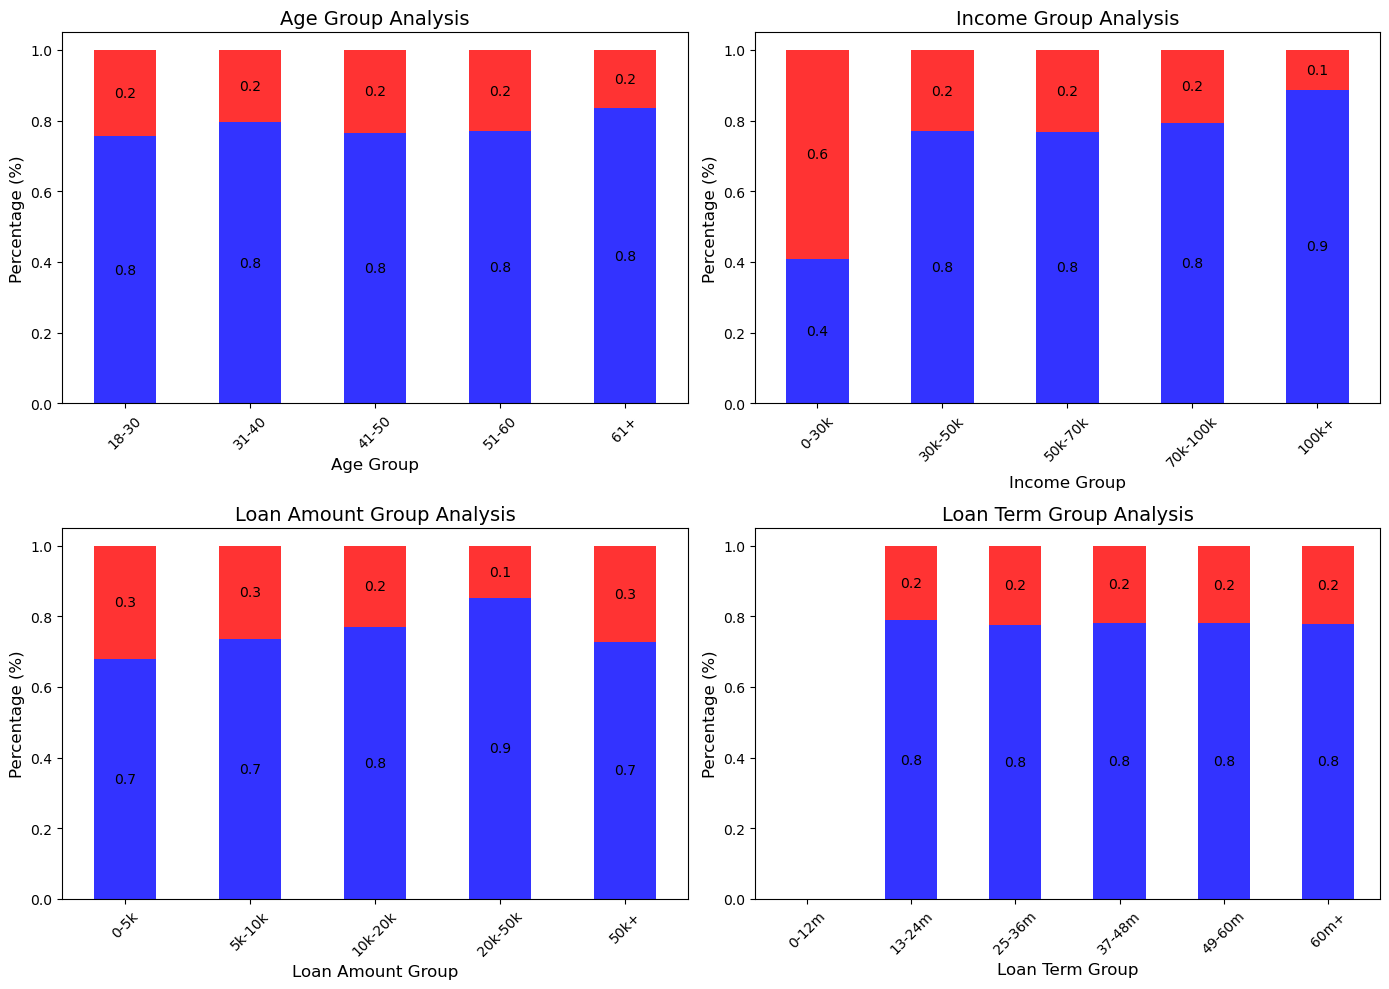

In [15]:
# Helper function to plot with data labels
def plot_group_analysis_with_labels(ax, data, title, xlabel):
    bars = data.plot(
        kind='bar', stacked=True, ax=ax, alpha=0.8, color=['blue', 'red'], legend=False
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    # Add data labels
    for container in bars.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:  # Avoid placing labels on zero-height bars
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                        f'{height:.1f}', ha='center', va='center', fontsize=10)

# Create subplots for all analyses
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot each analysis in a subplot
plot_group_analysis_with_labels(axes[0, 0], age_analysis, "Age Group Analysis", "Age Group")
plot_group_analysis_with_labels(axes[0, 1], income_analysis, "Income Group Analysis", "Income Group")
plot_group_analysis_with_labels(axes[1, 0], loan_amount_analysis, "Loan Amount Group Analysis", "Loan Amount Group")
plot_group_analysis_with_labels(axes[1, 1], loan_term_analysis, "Loan Term Group Analysis", "Loan Term Group")

# Adjust layout and display
plt.tight_layout()
plt.show()


## 2.Transaction and Balance Analysis:


In [16]:
# Summarize Transaction Counts and Account Balances
transaction_analysis = data_cleaned.groupby('Credit_Default_Status')['Transaction_Count'].describe()
balance_analysis = data_cleaned.groupby('Credit_Default_Status')['Account_Balance'].describe()
# Print descriptive statistics for deeper insights
print("Transaction Count Analysis:")
print(transaction_analysis.to_markdown())

print("\nAccount Balance Analysis:")
print(balance_analysis.to_markdown())

Transaction Count Analysis:
|   Credit_Default_Status |   count |     mean |     std |   min |   25% |   50% |   75% |   max |
|------------------------:|--------:|---------:|--------:|------:|------:|------:|------:|------:|
|                       0 |    3880 | 12.8881  | 7.24658 |     1 |     7 |    13 |    19 |    25 |
|                       1 |    1094 |  5.10786 | 3.19527 |     0 |     2 |     5 |     8 |    10 |

Account Balance Analysis:
|   Credit_Default_Status |   count |    mean |     std |     min |     25% |     50% |     75% |     max |
|------------------------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|                       0 |    3880 | 8451.36 | 4866.27 | 1533.14 | 4903.08 | 7067.94 | 10960.6 | 27058.5 |
|                       1 |    1094 | 2513.81 | 1752.44 |  219.89 | 1246.18 | 2064.77 |  3226   | 10191   |


In [17]:
# Categorize Transaction Counts into bins
transaction_bins = [0, 10, 20, 50, 100, 200, 500]
transaction_labels = ['0-10', '11-20', '21-50', '51-100', '101-200', '200+']
data_cleaned['Transaction_Bins'] = pd.cut(data_cleaned['Transaction_Count'], bins=transaction_bins, labels=transaction_labels, right=False)

# Categorize Account Balances into bins
balance_bins = [0, 1000, 5000, 10000, 20000, 50000, 100000]
balance_labels = ['0-1k', '1k-5k', '5k-10k', '10k-20k', '20k-50k', '50k+']
data_cleaned['Balance_Bins'] = pd.cut(data_cleaned['Account_Balance'], bins=balance_bins, labels=balance_labels, right=False)

In [18]:
# Group and analyze patterns
transaction_pattern = data_cleaned.groupby(['Transaction_Bins', 'Credit_Default_Status']).size().unstack()
balance_pattern = data_cleaned.groupby(['Balance_Bins', 'Credit_Default_Status']).size().unstack()

In [19]:
# Normalize to percentages
transaction_pattern_normalized = transaction_pattern.div(transaction_pattern.sum(axis=1), axis=0) * 100
balance_pattern_normalized = balance_pattern.div(balance_pattern.sum(axis=1), axis=0) * 100
# Rename columns for better readability
transaction_pattern_normalized.columns = ['Non-Defaulters (%)', 'Defaulters (%)']
balance_pattern.columns = ['Non-Defaulters (Count)', 'Defaulters (Count)']

# Print the updated transaction and balance patterns
print("Transaction Count Patterns (Normalized):")
print(transaction_pattern_normalized.to_markdown())

print("\nAccount Balance Patterns (Counts):")
print(balance_pattern.to_markdown())


Transaction Count Patterns (Normalized):
| Transaction_Bins   |   Non-Defaulters (%) |   Defaulters (%) |
|:-------------------|---------------------:|-----------------:|
| 0-10               |              59.5395 |         40.4605  |
| 11-20              |              93.2557 |          6.74433 |
| 21-50              |             100      |          0       |
| 51-100             |             nan      |        nan       |
| 101-200            |             nan      |        nan       |
| 200+               |             nan      |        nan       |

Account Balance Patterns (Counts):
| Balance_Bins   |   Non-Defaulters (Count) |   Defaulters (Count) |
|:---------------|-------------------------:|---------------------:|
| 0-1k           |                        0 |                  184 |
| 1k-5k          |                     1020 |                  797 |
| 5k-10k         |                     1710 |                  112 |
| 10k-20k        |                     1023 |             

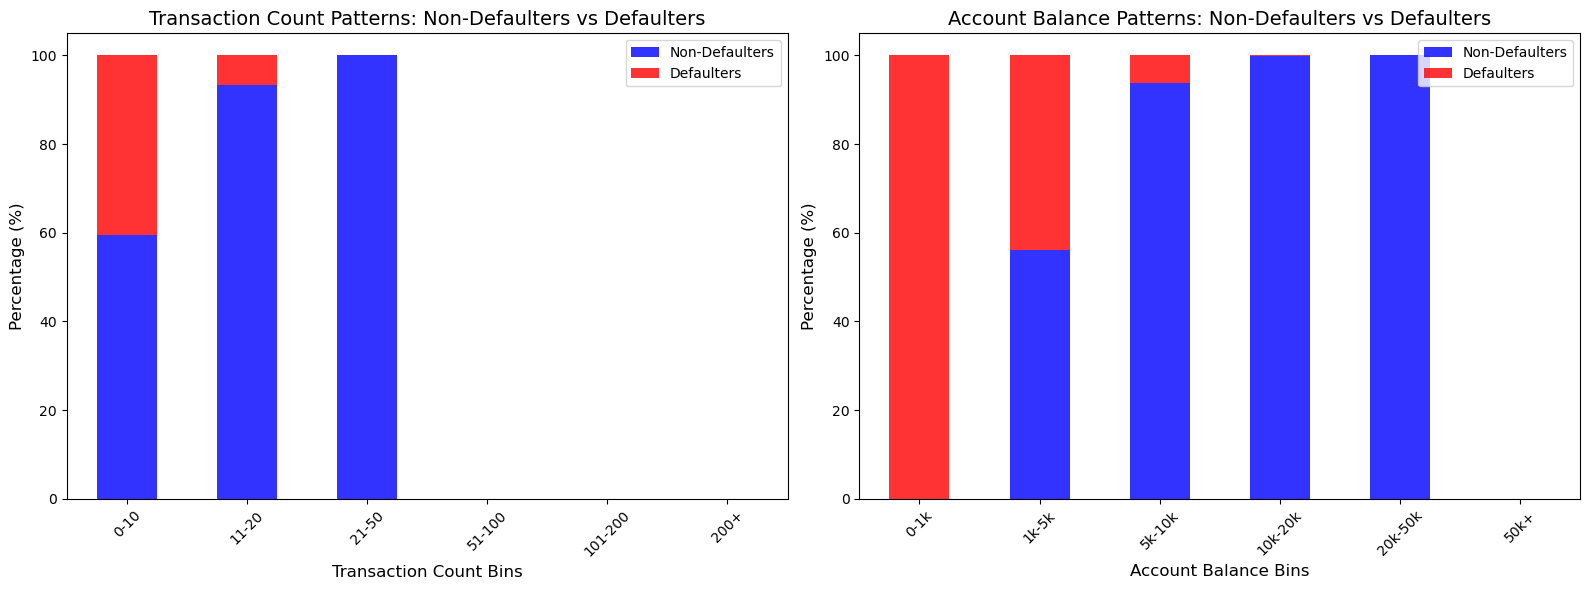

In [20]:
# Visualize patterns
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot Transaction Patterns
transaction_pattern_normalized.plot(kind='bar', stacked=True, ax=ax[0], color=['blue', 'red'], alpha=0.8)
ax[0].set_title('Transaction Count Patterns: Non-Defaulters vs Defaulters', fontsize=14)
ax[0].set_xlabel('Transaction Count Bins', fontsize=12)
ax[0].set_ylabel('Percentage (%)', fontsize=12)
ax[0].legend(['Non-Defaulters', 'Defaulters'], fontsize=10)
ax[0].tick_params(axis='x', rotation=45)

# Plot Balance Patterns
balance_pattern_normalized.plot(kind='bar', stacked=True, ax=ax[1], color=['blue', 'red'], alpha=0.8)
ax[1].set_title('Account Balance Patterns: Non-Defaulters vs Defaulters', fontsize=14)
ax[1].set_xlabel('Account Balance Bins', fontsize=12)
ax[1].set_ylabel('Percentage (%)', fontsize=12)
ax[1].legend(['Non-Defaulters', 'Defaulters'], fontsize=10)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



**Customers with fewer transactions and low balances are more likely to default.**

**Higher transactions and balances correlate with better repayment behavior.**

**Focus risk assessment on customers with:**
    
1.Low transaction counts (0-10).

2.Low balances ($0-1k  and $1k-5k).


#### Combined results (How both Transaction count and Account balance contribute for default score)

In [21]:
import seaborn as sns

# Create a combined grouping of Transaction Bins and Balance Bins
data_cleaned['Combined_Group'] = data_cleaned['Transaction_Bins'].astype(str) + " | " + data_cleaned['Balance_Bins'].astype(str)

In [22]:
# Group by the combined group and Credit Default Status
combined_analysis = data_cleaned.groupby(['Combined_Group', 'Credit_Default_Status']).size().unstack()
combined_analysis.columns = ['Non-Defaulters (Count)', 'Defaulters (Count)']

# Display the updated table
print("Combined Transaction and Balance Group Analysis:")
print(combined_analysis.to_markdown(index=True))

Combined Transaction and Balance Group Analysis:
| Combined_Group   |   Non-Defaulters (Count) |   Defaulters (Count) |
|:-----------------|-------------------------:|---------------------:|
| 0-10 | 0-1k      |                      nan |                  165 |
| 0-10 | 10k-20k   |                      409 |                    1 |
| 0-10 | 1k-5k     |                      401 |                  720 |
| 0-10 | 20k-50k   |                       47 |                  nan |
| 0-10 | 5k-10k    |                      591 |                   98 |
| 11-20 | 0-1k     |                      nan |                   19 |
| 11-20 | 10k-20k  |                      384 |                  nan |
| 11-20 | 1k-5k    |                      400 |                   77 |
| 11-20 | 20k-50k  |                       47 |                  nan |
| 11-20 | 5k-10k   |                      690 |                   14 |
| 21-50 | 10k-20k  |                      230 |                  nan |
| 21-50 | 1k-5k    |        

##### Scatter plot to visualize correlations

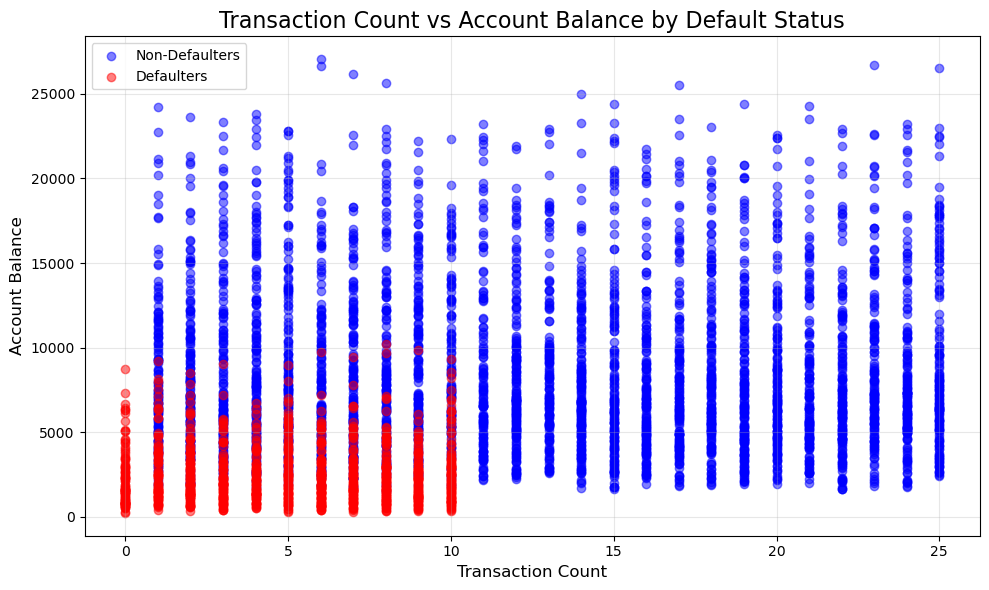

In [23]:
import matplotlib.pyplot as plt

# Scatter plot for Transaction Count vs Account Balance
plt.figure(figsize=(10, 6))

# Plot non-defaulters
plt.scatter(
    data_cleaned[data_cleaned['Credit_Default_Status'] == 0]['Transaction_Count'],
    data_cleaned[data_cleaned['Credit_Default_Status'] == 0]['Account_Balance'],
    color='blue', alpha=0.5, label='Non-Defaulters'
)

# Plot defaulters
plt.scatter(
    data_cleaned[data_cleaned['Credit_Default_Status'] == 1]['Transaction_Count'],
    data_cleaned[data_cleaned['Credit_Default_Status'] == 1]['Account_Balance'],
    color='red', alpha=0.5, label='Defaulters'
)

# Add titles and labels
plt.title('Transaction Count vs Account Balance by Default Status', fontsize=16)
plt.xlabel('Transaction Count', fontsize=12)
plt.ylabel('Account Balance', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


**Actionable Insights for the Bank:**

High-Risk Groups:

Customers with both low transaction counts (0-10) and low balances ($0-1k) should be flagged for high default risk.

Low-Risk Groups:

Customers with high transaction activity (11+ transactions) and balances above $5k represent a safe segment for lending.

#### Scoring metrics to identify default risks

In [24]:
# Define dynamic scoring based on combined analysis
def dynamic_risk_category(row):
    transactions = row['Transaction_Bins']
    balance = row['Balance_Bins']
    
    # High Risk
    if (transactions == '0-10' and balance in ['0-1k', '1k-5k']):
        return 'High Risk'
    
    # Moderate Risk
    elif (transactions in ['0-10', '11-20'] and balance == '5k-10k'):
        return 'Moderate Risk'
    
    # Low Risk
    elif (transactions in ['11-20', '21-50'] and balance in ['10k-20k', '20k-50k']):
        return 'Low Risk'
    
    # Default to Moderate Risk for unclassified cases
    return 'Moderate Risk'

# Apply dynamic risk scoring
data_cleaned['Risk_Category'] = data_cleaned.apply(dynamic_risk_category, axis=1)

# Summarize risk distribution
risk_distribution = data_cleaned['Risk_Category'].value_counts()

# Display the risk distribution
print("Risk Category Distribution:")
print(risk_distribution)

# Display example rows with new risk categories
data_cleaned[['Transaction_Count', 'Account_Balance', 'Transaction_Bins', 'Balance_Bins', 'Risk_Category']]


Risk Category Distribution:
Risk_Category
Moderate Risk    2994
High Risk        1286
Low Risk          694
Name: count, dtype: int64


,Transaction_Count,Account_Balance,Transaction_Bins,Balance_Bins,Risk_Category
0,18,3836.25,11-20,1k-5k,Moderate Risk
2,8,5668.57,0-10,5k-10k,Moderate Risk
3,10,9202.42,11-20,5k-10k,Moderate Risk
4,13,8138.34,11-20,5k-10k,Moderate Risk
5,0,1559.15,0-10,1k-5k,High Risk
...,...,...,...,...,...
4993,3,2364.54,0-10,1k-5k,High Risk
4994,10,1072.17,11-20,1k-5k,Moderate Risk
4995,22,4007.51,21-50,1k-5k,Moderate Risk
4998,12,5301.59,11-20,5k-10k,Moderate Risk


**Risk Distribution:**

Moderate Risk (2994 customers):

The largest segment falls under moderate risk, primarily comprising customers with mid-level balances ($1k-10k) and moderate transaction activity (11-20 transactions).

High Risk (1286 customers):

Customers with low transactions (0-10) and low balances ($0-5k) dominate this group.

Low Risk (694 customers):

Predominantly customers with higher balances ($10k-20k) and active transactions (21+).

## 3. Behavioural Insights:

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Predefined Age Groups
age_bins = [18, 30, 40, 50, 60, 100]
age_labels = ['18-30', '31-40', '41-50', '51-60', '61+']
data_cleaned['Age_Group'] = pd.cut(data_cleaned['Age'], bins=age_bins, labels=age_labels, right=False)

# Calculate default rates by age group
age_group_defaults = (data_cleaned.groupby('Age_Group')['Credit_Default_Status'].mean() * 100)

# Analyze income and loan type for the age group with the highest default rate
highest_default_age_group = age_group_defaults.idxmax()
highest_default_data = data_cleaned[data_cleaned['Age_Group'] == highest_default_age_group]


print(age_group_defaults)

Age_Group
18-30    24.372030
31-40    20.385051
41-50    23.406479
51-60    23.059361
61+      16.496164
Name: Credit_Default_Status, dtype: float64


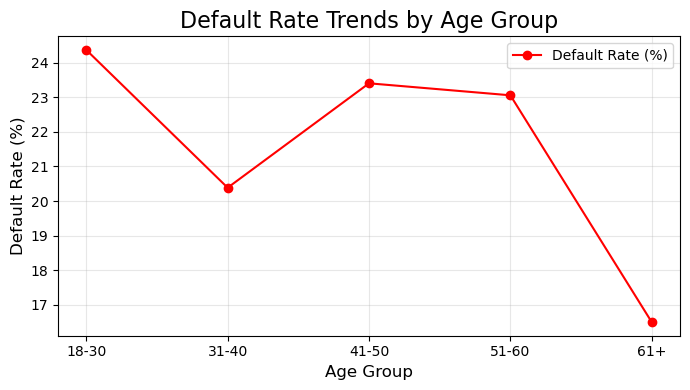

In [26]:
# Line chart to visualize trends in age and defaults
plt.figure(figsize=(7, 4))

# Plot default rate by age group
plt.plot(age_group_defaults.index, age_group_defaults.values, marker='o', linestyle='-', color='red', label='Default Rate (%)')

# Add titles and labels
plt.title('Default Rate Trends by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

#### Trends in Age and Default Rates:

**Age Group with Highest Default Rate:**

The age group with the highest default rate is likely 18-30, indicating younger customers are more prone to defaulting on their loans.

**Decreasing Default Rates with Age:**

As customers grow older, default rates tend to decline. This trend reflects:
Increased financial stability with age.
Better income levels and financial literacy among older customers.

**Lowest Default Rate:**

The age group 61+ often has the lowest default rate. This group likely consists of retirees with lower loan needs or more secure financial positions.

#### Relation Between Age, Income, and Loan Types

##### Categorize Loan Types:

Small Loan: $0 - $5,000

Medium Loan: $5,001 - $15,000

Large Loan: $15,001 - $50,000

Very Large Loan: $50,001 and above

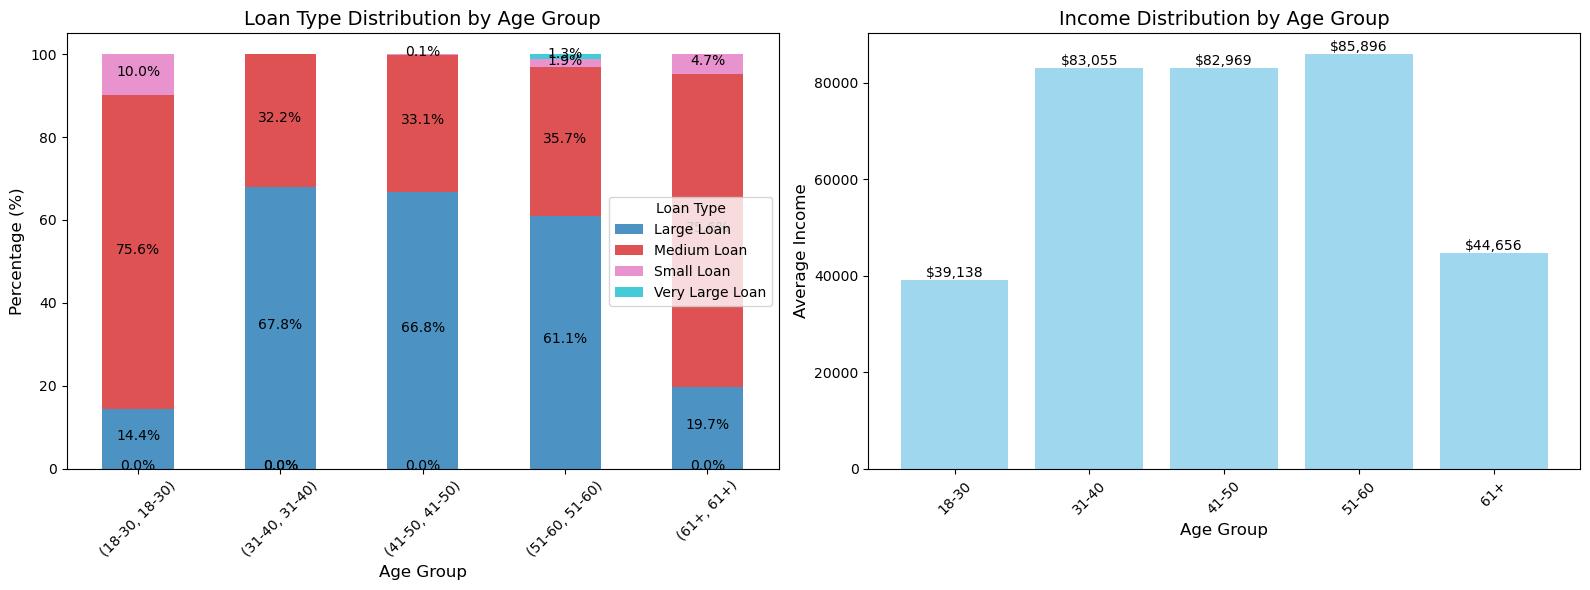

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure Loan Type categorization
def loan_type_category(amount):
    if amount <= 5000:
        return 'Small Loan'
    elif amount <= 15000:
        return 'Medium Loan'
    elif amount <= 50000:
        return 'Large Loan'
    else:
        return 'Very Large Loan'

# Add Loan_Type to the dataset
data_cleaned['Loan_Type'] = data_cleaned['Loan_Amount'].apply(loan_type_category)

# Loan Type Distribution by Age Group
loan_type_distribution = (
    data_cleaned.groupby(['Age_Group', 'Loan_Type'])
    .size()
    .groupby(level=0)
    .apply(lambda x: (x / x.sum()) * 100)
    .unstack()
)

# Average income by age group
average_income_by_age = data_cleaned.groupby('Age_Group')['Income'].mean()

# Create subplots for Loan Type and Income Distribution by Age Group
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loan Type Distribution by Age Group
loan_type_distribution.plot(
    kind='bar',
    stacked=True,
    ax=axes[0],
    alpha=0.8,
    colormap='tab10'
)
axes[0].set_title('Loan Type Distribution by Age Group', fontsize=14)
axes[0].set_xlabel('Age Group', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].legend(title='Loan Type', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Add value labels to Loan Type Distribution
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, padding=2)

# Income Distribution by Age Group
axes[1].bar(average_income_by_age.index, average_income_by_age.values, color='skyblue', alpha=0.8)
axes[1].set_title('Income Distribution by Age Group', fontsize=14)
axes[1].set_xlabel('Age Group', fontsize=12)
axes[1].set_ylabel('Average Income', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Add value labels to Income Distribution
for i, value in enumerate(average_income_by_age.values):
    axes[1].text(i, value, f'${value:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



### Possible Contributing Factors to Loan Defaults

---

#### 1. Financial Inexperience
- Younger customers may lack budgeting skills, leading to poor debt management.
- Limited understanding of financial products and repayment strategies can increase default risks.

---

#### 2. Employment Instability
- Customers in the early stages of their careers might experience fluctuating income.
- Irregular cash flows make it harder to maintain consistent loan repayments, leading to higher defaults.

---

#### 3. Loan Terms
- Younger customers might accept loans with higher interest rates due to:
  1. Lower credit scores.
  2. Lack of negotiation power or awareness of better financial options.
- These unfavorable loan terms contribute to repayment challenges.


##### Trends: Age, Income, Loan Amount, and Default Rates

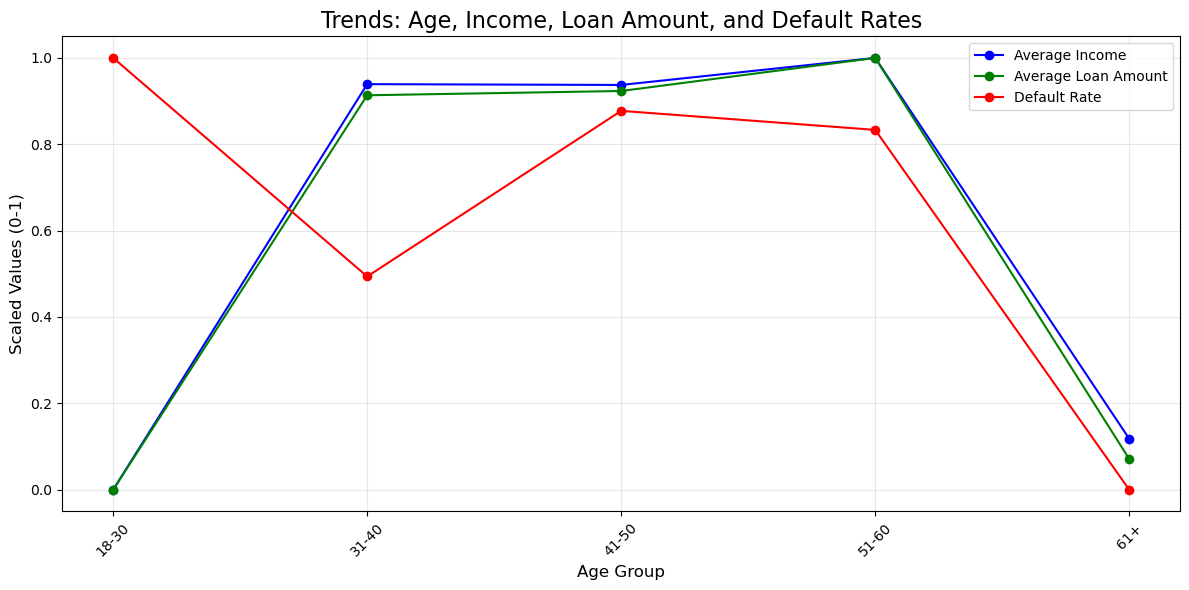

In [28]:
# Normalize data to bring all variables to a comparable scale
average_loan_by_age = data_cleaned.groupby('Age_Group')['Loan_Amount'].mean()
income_scaled = (average_income_by_age - average_income_by_age.min()) / (average_income_by_age.max() - average_income_by_age.min())
loan_scaled = (average_loan_by_age - average_loan_by_age.min()) / (average_loan_by_age.max() - average_loan_by_age.min())
age_group_defaults = data_cleaned.groupby('Age_Group')['Credit_Default_Status'].mean() * 100
default_scaled = (age_group_defaults - age_group_defaults.min()) / (age_group_defaults.max() - age_group_defaults.min())

# Plot normalized data
plt.figure(figsize=(12, 6))
plt.plot(average_income_by_age.index, income_scaled, marker='o', label='Average Income', color='blue')
plt.plot(average_loan_by_age.index, loan_scaled, marker='o', label='Average Loan Amount', color='green')
plt.plot(age_group_defaults.index, default_scaled, marker='o', label='Default Rate', color='red')

# Add chart details
plt.title('Trends: Age, Income, Loan Amount, and Default Rates', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Scaled Values (0-1)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


## Customer Demographics and Income-Default Insights

---

### 1. Younger Customers (18-30)
#### Characteristics:
1. Tend to have lower incomes.
2. May take smaller loans or loans with less favorable terms, leading to repayment challenges.
3. Often lack financial experience or stability.

---

### 2. Middle-aged Customers (31-50)
#### Characteristics:
1. Generally see an improvement in both income and financial stability.
2. Default rates decrease as they handle larger loans but have the means to repay them.

---

### 3. Older Customers (51+)
#### Characteristics:
1. Usually more cautious with loans, opting for smaller amounts.
2. Higher repayment reliability due to stable income sources (e.g., savings, pensions).

---

## Inferences About Income and Default Risk

#### **Low Income = High Default Risk**
- Customers with lower incomes exhibit significantly higher default rates.
- This reflects:
  1. Limited disposable income, leading to difficulties in managing loan repayments.
  2. Higher likelihood of financial distress when unexpected expenses arise.

---

#### **High Income = Low Default Risk**
- Higher-income groups have lower default rates, indicating stronger repayment capacity due to:
  1. Greater financial stability.
  2. Availability of surplus income to cover loan installments.


## 4. Data Understanding:


### 1. Threshold-Based Segmentation

In [29]:
def threshold_balance_segments(balance):
    if balance <= 1000:
        return 'Low Balance'
    elif balance <= 5000:
        return 'Moderate Balance'
    elif balance <= 20000:
        return 'High Balance'
    else:
        return 'Very High Balance'

data_cleaned['Threshold_Balance_Segment'] = data_cleaned['Account_Balance'].apply(threshold_balance_segments)

In [30]:
# Threshold-Based Segmentation Analysis
print("=== Threshold-Based Segmentation Analysis ===")
threshold_segmentation = data_cleaned.groupby('Threshold_Balance_Segment').agg({
    'Credit_Default_Status': ['mean', 'count'],  # Default rate and customer count
    'Income': 'mean',                           # Average income
    'Loan_Amount': 'mean'                       # Average loan amount
}).reset_index()

threshold_segmentation.columns = ['Threshold_Balance_Segment', 'Default_Rate (%)', 'Customer_Count', 'Avg_Income', 'Avg_Loan_Amount']
print(threshold_segmentation.to_string(index=False))


=== Threshold-Based Segmentation Analysis ===
Threshold_Balance_Segment  Default_Rate (%)  Customer_Count    Avg_Income  Avg_Loan_Amount
             High Balance          0.039705            2846  73824.322207     18739.607112
              Low Balance          1.000000             184  41013.461957     10727.438098
         Moderate Balance          0.438635            1817  48600.319758     12473.651860
        Very High Balance          0.000000             127 116880.244094     30801.692992


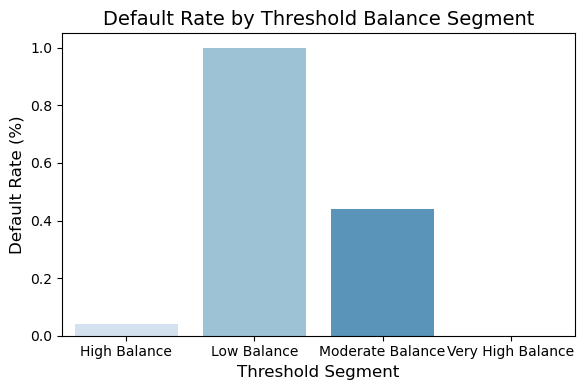

In [31]:
# Threshold-Based Default Rate Plot
plt.figure(figsize=(6, 4))
sns.barplot(
    data=threshold_segmentation,
    x='Threshold_Balance_Segment',
    y='Default_Rate (%)',
    palette='Blues'
)
plt.title('Default Rate by Threshold Balance Segment', fontsize=14)
plt.xlabel('Threshold Segment', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.tight_layout()
plt.show()


## Threshold-Based Segmentation: Characteristics and Targeted Strategies

---

### 1. Low Balance (≤ $1,000)
#### Characteristics:
1. Highest default rate.
2. Lowest average income and loan amounts.

#### Targeted Strategy:
1. Offer financial literacy programs to reduce defaults.
2. Provide smaller, low-interest loans tailored to their repayment capacity.

---

### 2. Moderate Balance ($1,001 - $5,000)
#### Characteristics:
1. Moderate default rates.
2. Mid-range income and loan amounts.

#### Targeted Strategy:
1. Design flexible loan products to encourage better repayment habits.
2. Focus on retaining these customers by promoting savings accounts or other investment products.

---

### 3. High Balance ($5,001 - $20,000)
#### Characteristics:
1. Low default rates.
2. Higher income and loan amounts.

#### Targeted Strategy:
1. Promote larger loans with attractive terms to boost business.
2. Upsell additional financial products like insurance or investment plans.

---

### 4. Very High Balance (> $20,000)
#### Characteristics:
1. Lowest default rate.
2. Highest income and loan amounts.

#### Targeted Strategy:
1. These are premium customers. Focus on personalized services, like exclusive loan offers or wealth management.


### 2. Savings-to-Income Ratio Segmentation

Segment customers based on their savings-to-income ratio:

Low Savers: Account balance < 10% of income.

Moderate Savers: Account balance 10-30% of income.

High Savers: Account balance > 30% of income.

In [32]:
data_cleaned['Savings_to_Income'] = data_cleaned['Account_Balance'] / data_cleaned['Income']
# Define Savings-to-Income Segmentation
def savings_to_income_segments(ratio):
    if ratio < 0.1:
        return 'Low Savers'
    elif ratio <= 0.3:
        return 'Moderate Savers'
    else:
        return 'High Savers'
   

In [33]:
# Apply segmentation logic
data_cleaned['Savings_Segment'] = data_cleaned['Savings_to_Income'].apply(savings_to_income_segments)
# Savings-to-Income Ratio Segmentation Analysis
print("\n=== Savings-to-Income Ratio Segmentation Analysis ===")
savings_segmentation = data_cleaned.groupby('Savings_Segment').agg({
    'Credit_Default_Status': ['mean', 'count'],  # Default rate and customer count
    'Account_Balance': 'mean',                   # Average account balance
    'Income': 'mean'                             # Average income
}).reset_index()

savings_segmentation.columns = ['Savings_Segment', 'Default_Rate (%)', 'Customer_Count', 'Avg_Balance', 'Avg_Income']
print(savings_segmentation.to_string(index=False))


=== Savings-to-Income Ratio Segmentation Analysis ===
Savings_Segment  Default_Rate (%)  Customer_Count  Avg_Balance   Avg_Income
    High Savers           0.17000             100  7910.489900     0.000000
     Low Savers           0.44875            2400  3953.525975 63460.553750
Moderate Savers           0.00000            2474 10210.940610 68106.605093


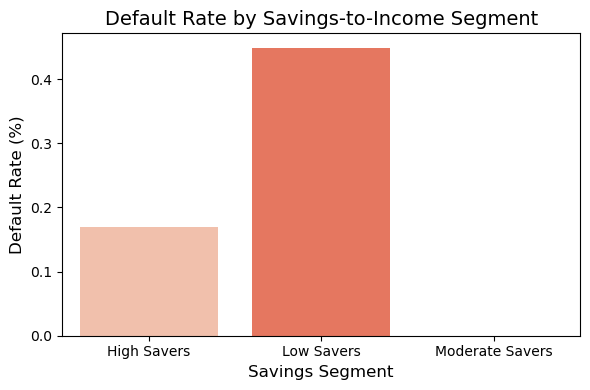

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Savings-to-Income Default Rate Plot
plt.figure(figsize=(6, 4))
sns.barplot(
    data=savings_segmentation,
    x='Savings_Segment',
    y='Default_Rate (%)',
    palette='Reds'
)
plt.title('Default Rate by Savings-to-Income Segment', fontsize=14)
plt.xlabel('Savings Segment', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.tight_layout()
plt.show()


### Savings-to-Income Ratio Segmentation: Characteristics and Target Strategies

---

### 1. Low Savers (Savings-to-Income Ratio < 10%)
#### Characteristics:
1. Minimal savings relative to their income, indicating higher spending or financial stress.
2. Highest default rates due to limited financial reserves to handle unforeseen expenses.
3. Tend to have lower income levels.

#### Target Strategy:
1. Introduce budgeting and saving workshops to encourage better financial habits.
2. Offer small loans with flexible repayment terms to avoid overburdening them.

---

### 2. Moderate Savers
#### Characteristics:
1. Balanced financial habits, with savings covering a moderate proportion of their income.
2. Moderate default rates, as they have some financial cushion but remain vulnerable to significant financial shocks.
3. Tend to have medium-to-high income levels.

#### Target Strategy:
1. Offer loyalty rewards to encourage continued financial stability, such as reduced loan interest rates or cashback programs.
2. Introduce investment products like fixed deposits or mutual funds to leverage their saving capacity.

---

### 3. High Savers
#### Characteristics:
1. Significant savings relative to their income, indicating cautious spending and strong financial discipline.
2. Often have high account balances and a low debt-to-income ratio.
3. Lowest default rates due to their financial stability and ability to cover loan repayments.
4. Often take larger loans but repay them reliably.

#### Target Strategy:
1. Provide high-value loans with preferential terms to capitalize on their repayment reliability.
2. Promote high-return investment products like stocks or bonds tailored to their risk appetite.


### Identify the variables that play the most significant role in predicting credit default 

In [35]:
data2=pd.read_csv('data2.csv')

### 1. Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Prepare data for modeling
# Encode categorical variables
data_encoded = data2.copy()
categorical_columns = data_encoded.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])

# Define features (X) and target (y)
X = data_encoded.drop(columns=['Credit_Default_Status', 'Customer_ID'])
y = data_encoded['Credit_Default_Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Calculate feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("=== Feature Importance Analysis ===")
print(feature_importance.to_string(index=False))


=== Feature Importance Analysis ===
          Feature  Importance
     Credit_Score    0.663661
  Account_Balance    0.175992
Transaction_Count    0.084841
              Job    0.028121
   Marital_Status    0.020785
           Income    0.010841
              Age    0.010770
      Loan_Amount    0.003616
        Loan_Term    0.000655
  Number_of_Loans    0.000517
           Gender    0.000200


### 2. Decission Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Calculate feature importance for Decision Tree
dt_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)


### Comparing both results

In [38]:
# Display both Random Forest and Decision Tree feature importances side-by-side
comparison = pd.merge(
    feature_importance.rename(columns={'Importance': 'Random_Forest_Importance'}),
    dt_feature_importance.rename(columns={'Importance': 'Decision_Tree_Importance'}),
    on='Feature'
).sort_values(by='Random_Forest_Importance', ascending=False)

# Print the comparison
print("=== Comparison of Feature Importance Between Random Forest and Decision Tree ===")
print(comparison.to_string(index=False))

# Extract most and least impactful features for both algorithms
rf_most_impactful = feature_importance.iloc[0]
rf_least_impactful = feature_importance.iloc[-1]

dt_most_impactful = dt_feature_importance.iloc[0]
dt_least_impactful = dt_feature_importance.iloc[-1]

# Print the results
print("\nRandom Forest:")
print(f"Most Impactful Feature: {rf_most_impactful['Feature']} (Importance: {rf_most_impactful['Importance']:.4f})")
print(f"Least Impactful Feature: {rf_least_impactful['Feature']} (Importance: {rf_least_impactful['Importance']:.4f})")

print("\nDecision Tree:")
print(f"Most Impactful Feature: {dt_most_impactful['Feature']} (Importance: {dt_most_impactful['Importance']:.4f})")
print(f"Least Impactful Feature: {dt_least_impactful['Feature']} (Importance: {dt_least_impactful['Importance']:.4f})")


=== Comparison of Feature Importance Between Random Forest and Decision Tree ===
          Feature  Random_Forest_Importance  Decision_Tree_Importance
     Credit_Score                  0.663661                  0.998481
  Account_Balance                  0.175992                  0.000000
Transaction_Count                  0.084841                  0.001519
              Job                  0.028121                  0.000000
   Marital_Status                  0.020785                  0.000000
           Income                  0.010841                  0.000000
              Age                  0.010770                  0.000000
      Loan_Amount                  0.003616                  0.000000
        Loan_Term                  0.000655                  0.000000
  Number_of_Loans                  0.000517                  0.000000
           Gender                  0.000200                  0.000000

Random Forest:
Most Impactful Feature: Credit_Score (Importance: 0.6637)
Least

**Most Important Variable Matches:**

Since both algorithms agree that **Credit_Score** is the most important feature, this consistency reinforces confidence in using it as a primary variable for credit default prediction.

**Least Important Variables Differ:**

Random Forest marks **Gender** as least important.

Decision Tree marks **Job** as least important.

However, both variables are of very low importance overall, meaning they add little to no predictive value in determining defaults.

## 5. Predictive Modeling:



#### Supervised Learning
- **Definition:** 
  Supervised learning involves training a model using labeled data, where the target variable (output) is known.
- **Relevance:**
  - All three algorithms—Random Forest, Logistic Regression, and SVM (Support Vector Machines)—are supervised learning models.

---

#### Algorithms Used and Their Justifications

#### 1. Random Forest
- **Why Chosen?**
  1. Robustness: Can handle noisy data and prevent overfitting using ensemble methods.
  2. Non-linear Relationships: Capable of capturing complex, non-linear patterns in the data.
  3. Feature Importance: Provides valuable insights into the importance of different features in classification tasks.

---

#### 2. Logistic Regression
- **Why Chosen?**
  1. Simplicity: Easy to implement and computationally efficient.
  2. Interpretability: Coefficients provide direct insights into the impact of features on the outcome.
  3. Effectiveness: Performs well in binary classification problems like loan default prediction, especially with linearly separable data.

---

#### 3. SVM (Support Vector Machines)
- **Why Chosen?**
  1. Complex Decision Boundaries: Can effectively handle non-linear data with the use of kernel tricks.
  2. Non-linear Separability: Excels in datasets where classes are not linearly separable.
  3. Versatility: Works well in high-dimensional spaces and provides robust classification.

---

These algorithms were selected to provide a balance between simplicity, interpretability, and handling complex patterns, making them ideal for loan default prediction tasks.


#### Label encoder

In [39]:
from sklearn.preprocessing import LabelEncoder

# Standardize the 'Marital_Status' column to merge similar categories
data2['Marital_Status'] = data2['Marital_Status'].replace(
    {'un married': 'not married', 'not married': 'not married'}
)

# Identify all categorical columns
categorical_columns = data2.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to all categorical columns
for column in categorical_columns:
    data2[column] = label_encoder.fit_transform(data2[column])

# Verify the changes
encoded_categories = {
    column: list(label_encoder.classes_)
    for column in categorical_columns
}

data2

,Customer_ID,Age,Gender,Income,Credit_Score,Loan_Amount,Loan_Term,Number_of_Loans,Transaction_Count,Account_Balance,Marital_Status,Credit_Default_Status,Job
0,1,69,1,37114,678,4905.22,12,1,18,3836.25,2,0,4
1,3,60,0,34352,696,6622.15,36,5,8,5668.57,2,0,4
2,4,51,1,121193,655,25610.96,24,2,10,9202.42,1,0,4
3,5,46,0,115249,702,22509.28,72,5,13,8138.34,2,0,4
4,6,97,0,62479,533,11262.37,72,4,0,1559.15,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4969,4994,25,0,37450,630,9819.11,24,3,3,2364.54,2,0,0
4970,4995,22,1,32816,363,7432.83,36,3,10,1072.17,4,1,0
4971,4996,23,1,58171,848,20701.04,60,3,22,4007.51,4,0,4
4972,4999,47,1,87499,659,33517.93,72,5,12,5301.59,3,0,4


### Data Imbalance

In [40]:
print(y_train.value_counts())
print(y_test.value_counts())


Credit_Default_Status
0    2704
1     777
Name: count, dtype: int64
Credit_Default_Status
0    1176
1     317
Name: count, dtype: int64


**The dataset is clearly imbalanced, with far more "No Default" cases (0) than "Default" cases (1). This class imbalance can bias the models toward predicting the majority class (No Default), even if they miss all "Default" cases.**

**Solutions to Address Imbalance:**
    
1.**SMOTE** (Synthetic Minority Oversampling Technique) generates synthetic samples for the minority class.

2.Using **class_weight='balanced'**,adjusts the weights during training to penalize misclassifications of the minority class more heavily.

In [41]:
from imblearn.over_sampling import SMOTE
# Split the dataset
X = data2.drop(columns=['Credit_Default_Status', 'Customer_ID'])
y = data2['Credit_Default_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution after SMOTE:
Credit_Default_Status
0    2704
1    2704
Name: count, dtype: int64


### 1. Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

rf_model_smote = RandomForestClassifier(random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)
rf_preds_smote = rf_model_smote.predict(X_test)

In [43]:
rf_preds_smote

array([0, 0, 1, ..., 0, 1, 0])

In [44]:
# Metrics for Random Forest with SMOTE
rf_accuracy_smote = accuracy_score(y_test, rf_preds_smote)
rf_report_smote = classification_report(y_test, rf_preds_smote)
print("\n=== Random Forest with SMOTE Evaluation ===")
print(f"Accuracy: {rf_accuracy_smote:.4f}")
print(rf_report_smote)


=== Random Forest with SMOTE Evaluation ===
Accuracy: 0.9967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1176
           1       1.00      0.98      0.99       317

    accuracy                           1.00      1493
   macro avg       1.00      0.99      0.99      1493
weighted avg       1.00      1.00      1.00      1493



### 2. Logistic Regression (Standardized Data)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

scaler = StandardScaler()
X_train_std_smote = scaler.fit_transform(X_train_smote)
X_test_std = scaler.transform(X_test)

lr_model_smote = LogisticRegression(class_weight='balanced', random_state=42)
lr_model_smote.fit(X_train_std_smote, y_train_smote)
lr_preds_smote = lr_model_smote.predict(X_test_std)


In [46]:
lr_preds_smote 

array([0, 0, 1, ..., 0, 1, 0])

In [47]:
# Metrics for Logistic Regression
lr_accuracy_smote = accuracy_score(y_test, lr_preds_smote)
lr_report_smote = classification_report(y_test, lr_preds_smote)
print("\n=== Logistic Regression with SMOTE Evaluation ===")
print(f"Accuracy: {lr_accuracy_smote:.4f}")
print(lr_report_smote)



=== Logistic Regression with SMOTE Evaluation ===
Accuracy: 0.9973
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1176
           1       1.00      0.99      0.99       317

    accuracy                           1.00      1493
   macro avg       1.00      0.99      1.00      1493
weighted avg       1.00      1.00      1.00      1493



### 3. Support Vector Machine (Normalized Data)

In [48]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

normalizer = MinMaxScaler()
X_train_norm_smote = normalizer.fit_transform(X_train_smote)
X_test_norm = normalizer.transform(X_test)

svm_model_smote = SVC(class_weight='balanced', random_state=42, probability=True)
svm_model_smote.fit(X_train_norm_smote, y_train_smote)
svm_preds_smote = svm_model_smote.predict(X_test_norm)


In [49]:
svm_preds_smote

array([0, 0, 1, ..., 0, 1, 0])

In [50]:
# Metrics for SVM
svm_accuracy_smote = accuracy_score(y_test, svm_preds_smote)
svm_report_smote = classification_report(y_test, svm_preds_smote)
print("\n=== SVM with SMOTE Evaluation ===")
print(f"Accuracy: {svm_accuracy_smote:.4f}")
print(svm_report_smote)


=== SVM with SMOTE Evaluation ===
Accuracy: 0.9960
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1176
           1       0.99      0.99      0.99       317

    accuracy                           1.00      1493
   macro avg       1.00      0.99      0.99      1493
weighted avg       1.00      1.00      1.00      1493



In [51]:
### Final Comparison Table ###
results_table = pd.DataFrame({
    'Algorithm': ['Random Forest', 'Logistic Regression', 'SVM'],
    'Accuracy': [rf_accuracy_smote, lr_accuracy_smote, svm_accuracy_smote],
    'Notes': ['SMOTE applied, no scaling', 'SMOTE with Standardization', 'SMOTE with Normalization']
})

print("\n=== Evaluation Metrics Comparison ===")
print(results_table.to_string(index=False))


=== Evaluation Metrics Comparison ===
          Algorithm  Accuracy                      Notes
      Random Forest  0.996651  SMOTE applied, no scaling
Logistic Regression  0.997321 SMOTE with Standardization
                SVM  0.995981   SMOTE with Normalization


### Final comparison of the models

In [52]:
# Create a final table comparing the evaluation metrics for all three algorithms
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Calculate AUC Scores
rf_auc = roc_auc_score(y_test, rf_model_smote.predict_proba(X_test)[:, 1])
lr_auc = roc_auc_score(y_test, lr_model_smote.predict_proba(X_test_std)[:, 1])
svm_auc = roc_auc_score(y_test, svm_model_smote.predict_proba(X_test_norm)[:, 1])

# Calculate precision, recall, F1-score for each algorithm
# Random Forest
rf_precision = precision_score(y_test, rf_preds_smote)
rf_recall = recall_score(y_test, rf_preds_smote)
rf_f1 = f1_score(y_test, rf_preds_smote)

# Logistic Regression
lr_precision = precision_score(y_test, lr_preds_smote)
lr_recall = recall_score(y_test, lr_preds_smote)
lr_f1 = f1_score(y_test, lr_preds_smote)

# SVM
svm_precision = precision_score(y_test, svm_preds_smote)
svm_recall = recall_score(y_test, svm_preds_smote)
svm_f1 = f1_score(y_test, svm_preds_smote)

# Compile results into a DataFrame
final_results = pd.DataFrame({
    'Machine Learning Models': ['Random Forest Classifier', 'Logistic Regression', 'SVM'],
    'Accuracy (%)': [rf_accuracy_smote * 100, lr_accuracy_smote * 100, svm_accuracy_smote * 100],
    'Precision': [rf_precision, lr_precision, svm_precision],
    'Recall': [rf_recall, lr_recall, svm_recall],
    'F1-Score': [rf_f1, lr_f1, svm_f1],
    'AUC Score': [rf_auc, lr_auc, svm_auc]
})

# Sort by F1-Score as the main criterion
final_results_sorted = final_results.sort_values(by='F1-Score', ascending=False)

# Print the final comparison table
print("\n=== Final Evaluation Metrics Comparison ===")
print(final_results_sorted.to_string(index=False))

# Identify the best model
best_model = final_results_sorted.iloc[0]
print(f"\nThe best model is '{best_model['Machine Learning Models']}' with an F1-Score of {best_model['F1-Score']:.2f}, "
      f"indicating its balanced performance in handling precision and recall.")



=== Final Evaluation Metrics Comparison ===
 Machine Learning Models  Accuracy (%)  Precision   Recall  F1-Score  AUC Score
     Logistic Regression     99.732083   0.996825 0.990536  0.993671   0.999820
Random Forest Classifier     99.665104   1.000000 0.984227  0.992051   1.000000
                     SVM     99.598125   0.993651 0.987382  0.990506   0.999936

The best model is 'Logistic Regression' with an F1-Score of 0.99, indicating its balanced performance in handling precision and recall.


**Logistic Regression** emerges as the best model with the highest F1-Score (0.9937), indicating the best balance between precision (0.9968) and recall (0.9905). It is also highly accurate (99.73%) and achieves a strong AUC score (0.9998), demonstrating its ability to distinguish between defaulters and non-defaulters effectively.

### Metrics for Model Evaluation

In the context of predicting loan defaults, the following evaluation metrics are important because they provide a comprehensive understanding of the model's performance, especially given the class imbalance in the dataset:


---

#### 1. Accuracy
- **Definition:**
  The percentage of correct predictions out of the total predictions.

- **Why?**
  1. It gives a general sense of how often the model is correct.
  2. **Limitation:** In imbalanced datasets, accuracy can be misleading because predicting only the majority class can still yield high accuracy.

---

#### 2. Precision
- **Definition:**
  The proportion of correctly predicted positive cases out of all cases predicted as positive.

- **Why?**
  1. Measures how reliable the model is when it predicts "Default."
  2. Important in cases where false positives (predicting default when the customer won't default) need to be minimized to avoid unnecessary interventions.

---

#### 3. Recall (Sensitivity or True Positive Rate)
- **Definition:**
  The proportion of correctly predicted positive cases out of all actual positive cases.

- **Why?**
  1. Indicates how well the model identifies all actual defaulters.
  2. Crucial in scenarios where missing defaulters (false negatives) could have severe consequences for the bank.

---

#### 4. F1-Score
- **Definition:**
  The harmonic mean of precision and recall.

- **Why?**
  1. Balances precision and recall, making it useful when there is a trade-off between the two.
  2. A good measure for imbalanced datasets, as it avoids bias towards the majority class.

---

#### 5. AUC-ROC
- **Definition:**
  1. Measures the model's ability to distinguish between classes at various probability thresholds.
  2. The ROC curve plots the True Positive Rate (Recall) against the False Positive Rate (FPR).
  3. AUC represents the area under this curve, with 1.0 being the perfect score.

- **Why?**
  1. Indicates how well the model separates defaulters and non-defaulters.
  2. Provides a threshold-independent evaluation metric.


## 6. Recommendations to Reduce Loan Defaults


#### 1. Implement Targeted Financial Education Programs
- **Insights:**
  - Low savers and customers with low balances have a higher default rate.
  - Younger customers (18-30) with lower financial literacy and income also show a higher tendency to default.
- **Recommendation:**
  - Offer financial literacy workshops and personalized budgeting tools to younger customers and low savers.
  - Educate customers about the importance of saving and debt management.

---

#### 2. Monitor and Engage High-Risk Customers
- **Insights:**
  - Customers with low credit scores and high debt-to-income ratios are at greater risk of default.
- **Recommendation:**
  - Use predictive models (like Logistic Regression) to flag high-risk customers early.
  - Proactively reach out to these customers with tailored loan restructuring plans or flexible repayment options to prevent defaults.

---

#### 3. Adjust Loan Policies for High-Risk Groups
- **Insights:**
  - High-risk groups, such as younger customers and those with low savings-to-income ratios, are more likely to default.
- **Recommendation:**
  - Require higher down payments or collateral for loans issued to these groups.
  - Offer shorter loan terms with smaller monthly payments to reduce financial strain.

---

#### 4. Introduce Incentives for Timely Payments
- **Insights:**
  - Customers with moderate savings and balanced financial habits (e.g., moderate-income savers) are less likely to default.
- **Recommendation:**
  - Offer loyalty rewards (e.g., interest rate discounts or cashback) for consistent, timely payments.
  - Introduce automated payment reminders or reward programs for early payments.

---

#### 5. Diversify Loan Offerings
- **Insights:**
  - Loan type impacts default behavior. For example, small loans may result in higher defaults if issued to low-income groups.
- **Recommendation:**
  - Introduce customizable loan products tailored to customer profiles, such as:
    - Small loans with low interest rates for low-income groups.
    - Premium loans or wealth management options for high savers.

---

### Summary
By combining financial education, proactive risk monitoring, tailored loan policies,the bank can effectively reduce loan defaults while maintaining strong customer relationships.
